# CellRank pipeline with Experimental time Kernel

In [59]:
import sys
#!pip install -q git+https://github.com/theislab/cellrank
#!pip install moscot
import cellrank as cr
from cellrank.kernels import RealTimeKernel
from moscot.problems.time import TemporalProblem
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

In [60]:
sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

In [61]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)

### Initialization 

In [62]:
adata = sc.read("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Matrix/p2.h5ad")
adata

AnnData object with n_obs × n_vars = 54606 × 18723
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'timepoint', 'doublet_finder', 'percent.mt', 'qc_pass', 'RNA_snn_res.0.1', 'seurat_clusters', 'RNA.weight', 'ADT.weight', 'wsnn_res.0.1', 'SingleR', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'manual_annotation', 'final_annot', 'annotation', 'Annotation'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank'
    uns: 'neighbors'
    obsm: 'X_adt.umap', 'X_integrated_dr', 'X_pca', 'X_ref.umap', 'X_tsne', 'X_umap', 'X_wnn.umap'
    varm: 'PCs'
    obsp: 'distances'

In [63]:
print(f"This detected {adata.var['vf_vst_counts_variable'].sum()} highly variable genes. ")

This detected 2000 highly variable genes. 


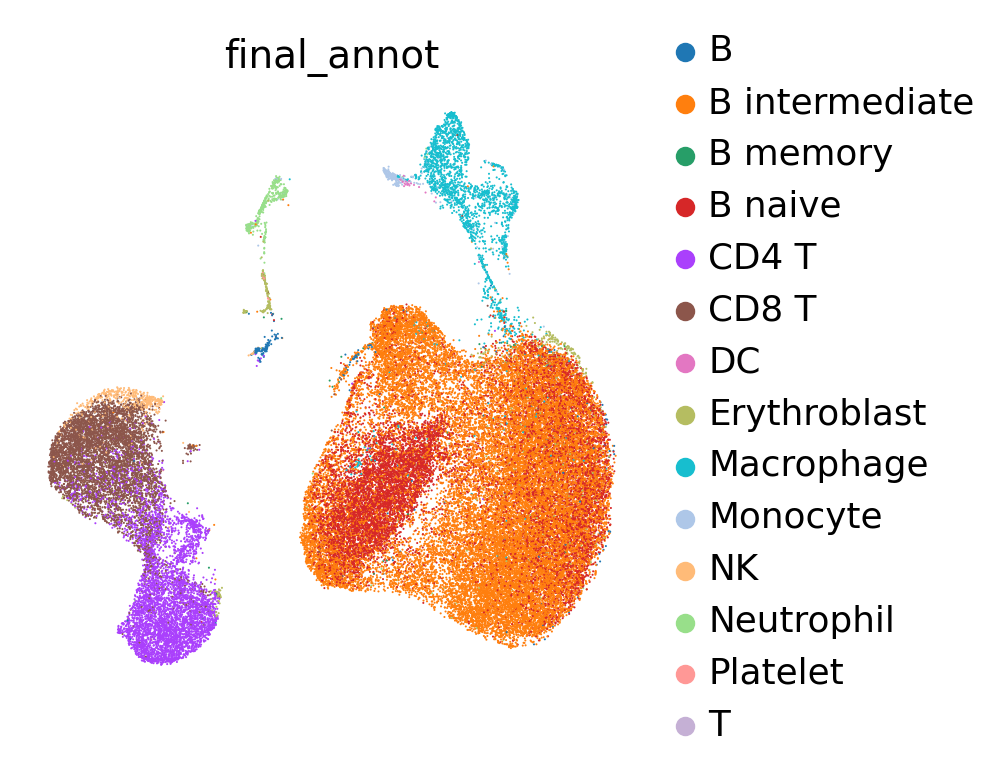

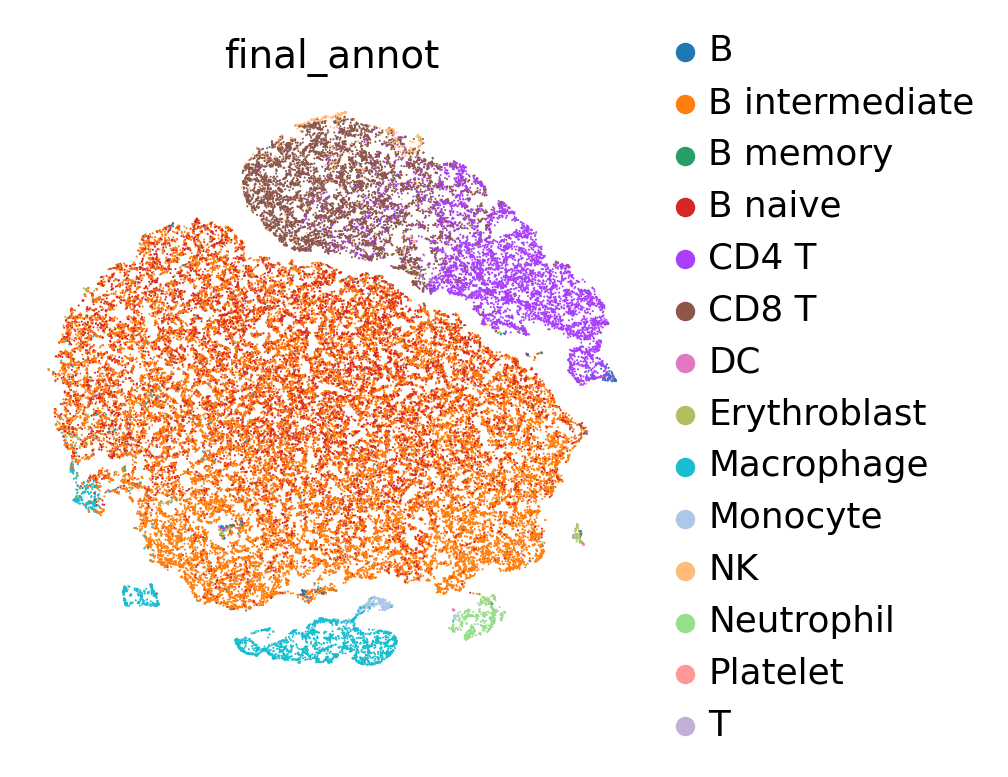

In [64]:
sc.pl.embedding(adata, basis="X_umap", color=["final_annot"])
sc.pl.embedding(adata, basis="X_tsne", color=["final_annot"])

In [65]:
# Extraire le nombre après 'D' et convertir en float
adata.obs["day_numerical"] = adata.obs["timepoint"].str.extract('D(\d+)').astype(float)

# Garder category pour le kernel (ordre alphabétique préservé si D1<D11<D14...)
adata.obs["timepoint"] = adata.obs["timepoint"].astype("category")

print(adata.obs[["timepoint", "day_numerical"]].head())
print(adata.obs[["timepoint", "day_numerical"]].tail())

                      timepoint  day_numerical
D1_AAACCCAAGTCCCGAC-1        D1            1.0
D1_AAACCCACACGCTGTG-1        D1            1.0
D1_AAACCCACATAGCACT-1        D1            1.0
D1_AAACCCACATGGCCCA-1        D1            1.0
D1_AAACCCAGTCTTTCTA-1        D1            1.0
                       timepoint  day_numerical
D14_TTTGTTGTCAATCTTC-1       D14           14.0
D14_TTTGTTGTCAGGACAG-1       D14           14.0
D14_TTTGTTGTCATTATCC-1       D14           14.0
D14_TTTGTTGTCCAGTACA-1       D14           14.0
D14_TTTGTTGTCTCTAGGA-1       D14           14.0


In [66]:
cell_types_to_keep = [ 'B intermediate', 'B memory', 'B naive', 'Bridge', 'Monocyte', 'Macrophage',]
adata = adata[adata.obs['Annotation'].isin(cell_types_to_keep)].copy()

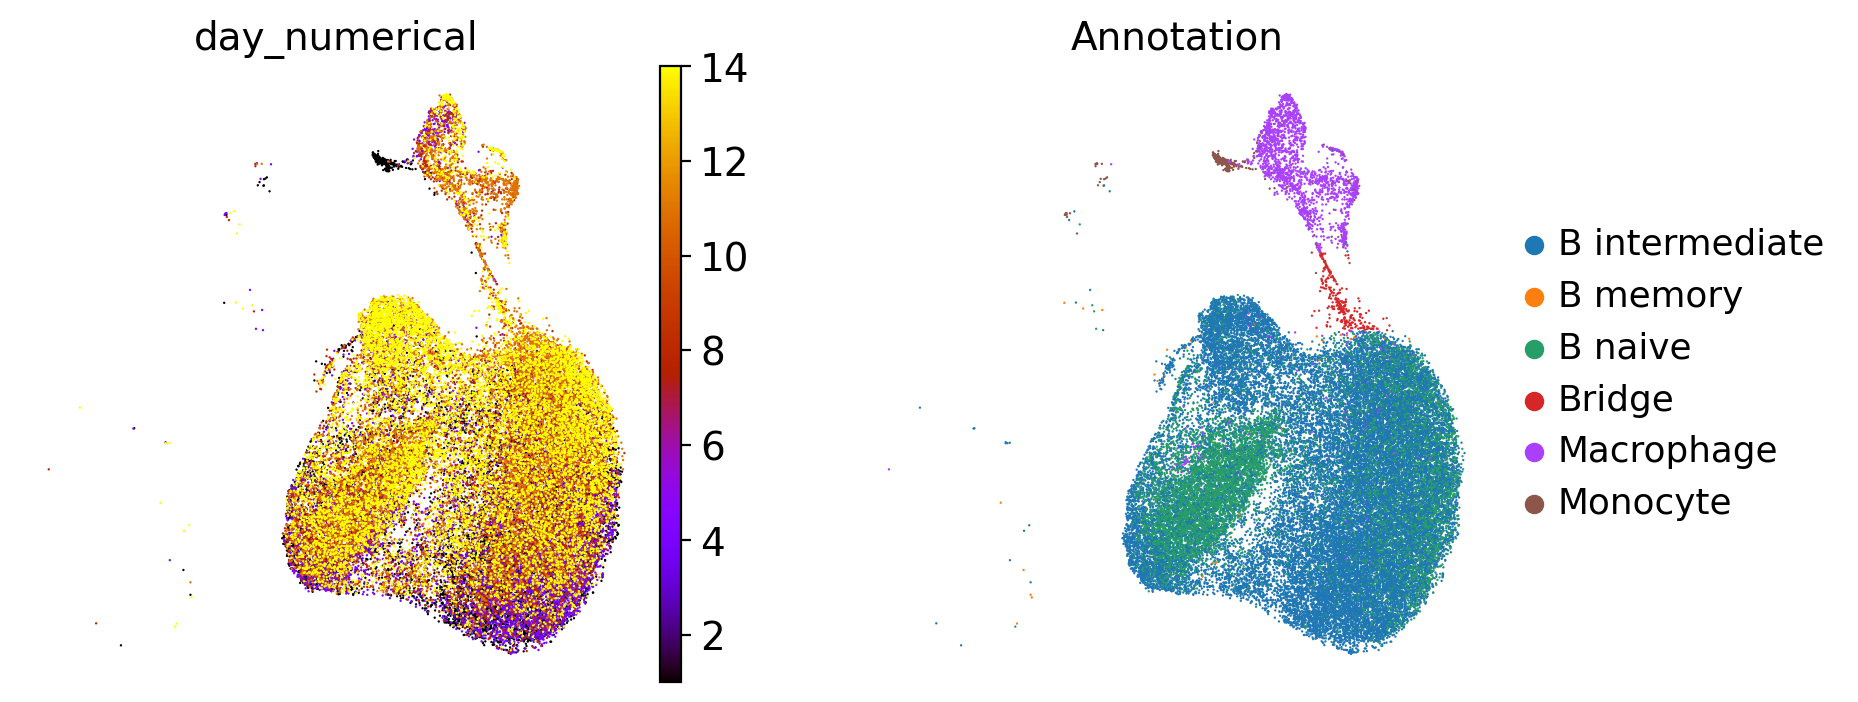

In [67]:
sc.pl.embedding(
    adata,
    basis= "X_umap",
    color=["day_numerical", "Annotation"],
    color_map="gnuplot",
)

## Reconstruct differentiation trajectories across time points

In [68]:
tp = TemporalProblem(adata)

In [69]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="human", gene_set_apoptosis="human"
)

computing score 'proliferation'
    finished (0:00:00)
computing score 'apoptosis'
    finished (0:00:00)


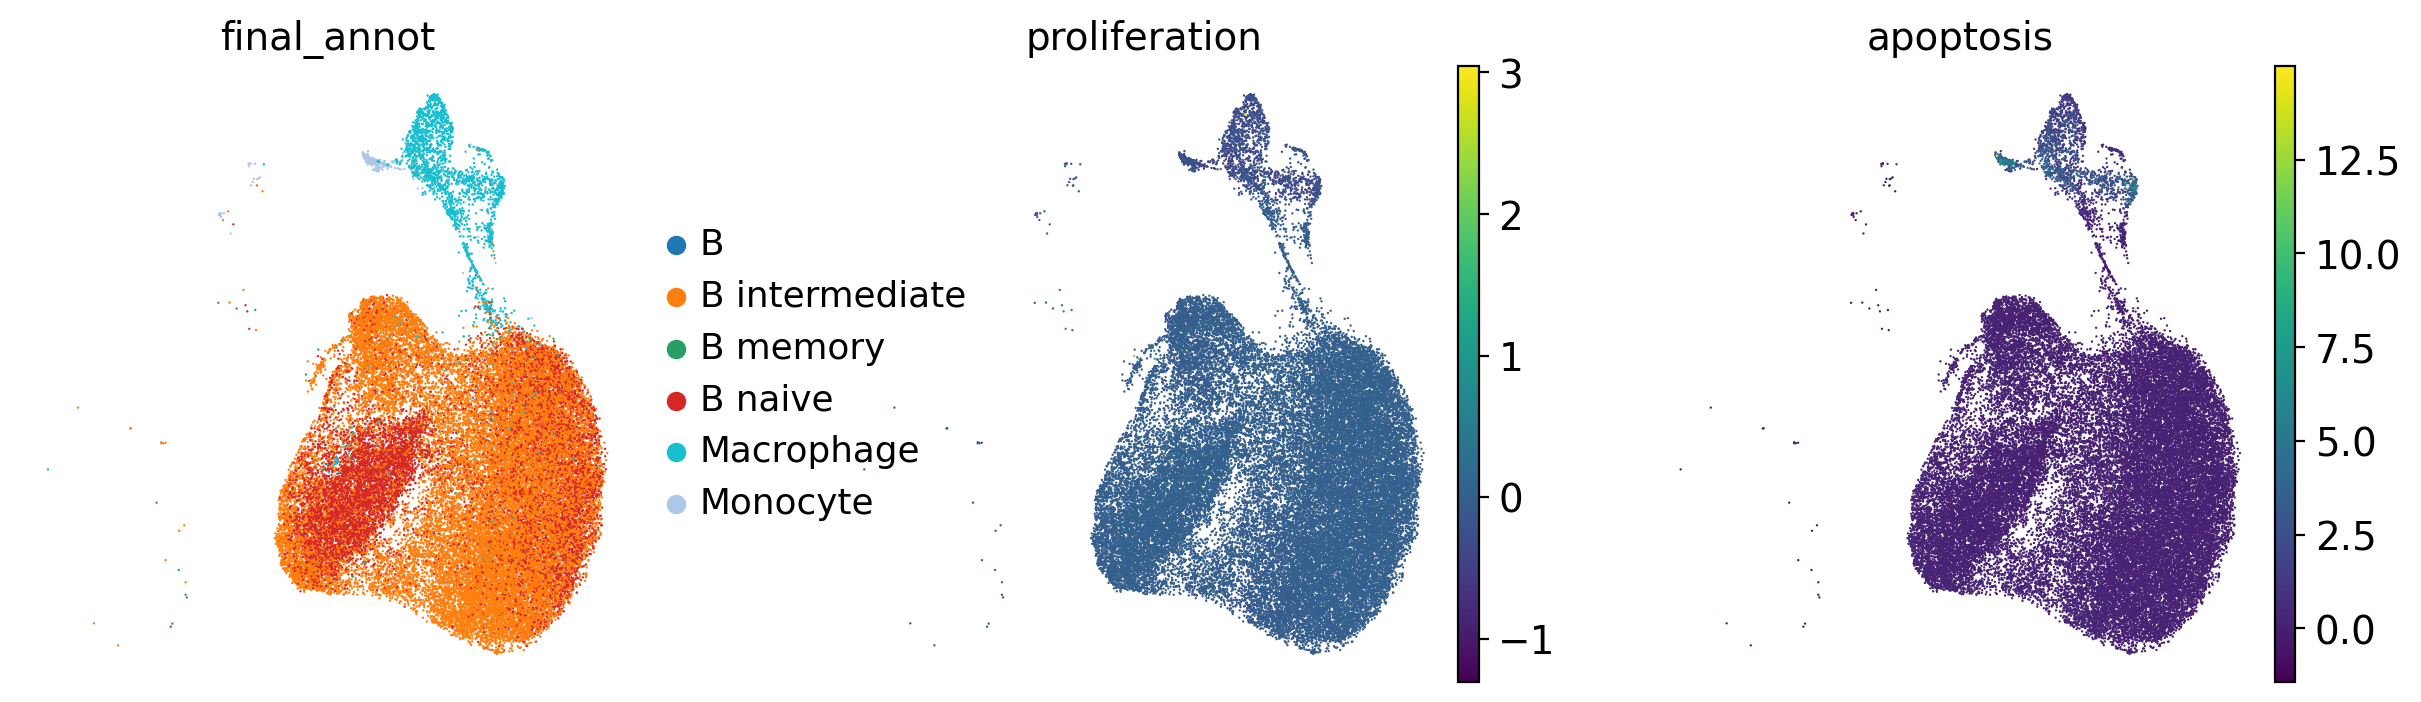

In [70]:
sc.pl.embedding(
    adata, basis="X_umap", color=["final_annot", "proliferation", "apoptosis"]
)

In [71]:
tp = tp.prepare(time_key="day_numerical")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:07)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:07)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:07)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:06)


In [72]:
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

INFO     Solving `4` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(6804, 8047)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(8047, 8398)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(8398, 11056)].                                 
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(7696, 6804)].                                  


### Compute RealTimeKernel

In [73]:
tmk = RealTimeKernel.from_moscot(tp)

In [74]:
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

  0%|          | 0/4 [00:00<?, ?time pair/s]

Using automatic `threshold=4.958610696155786e-19`


RealTimeKernel[n=42001, threshold='auto', self_transitions='all']

Simulating `100` random walks of maximum length `500`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:10)
Plotting random walks


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


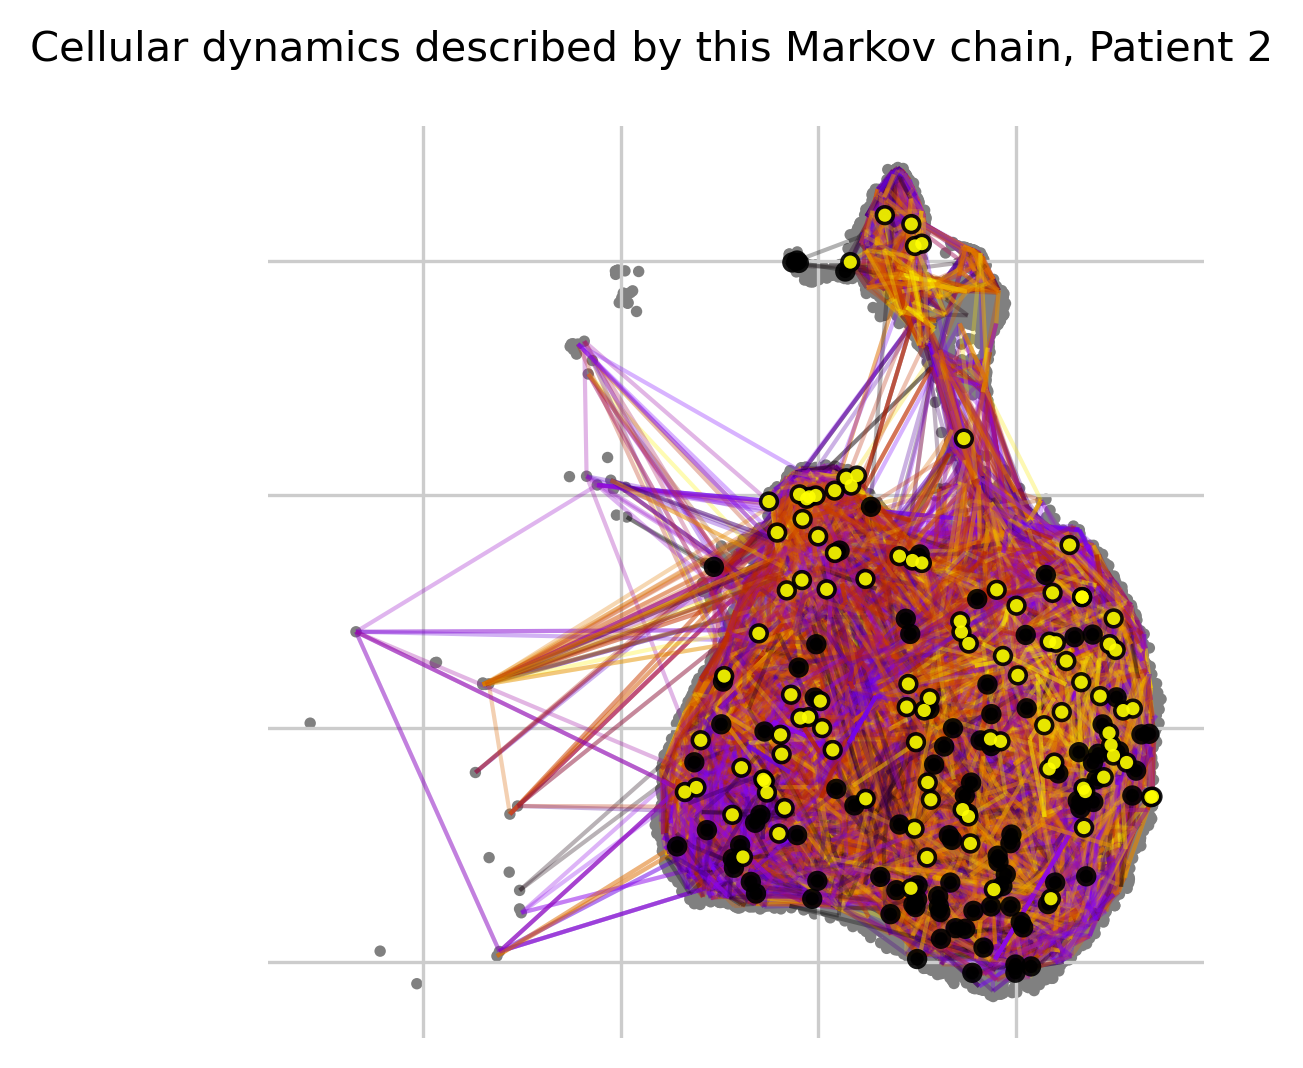

In [75]:
tmk.plot_random_walks(
    max_iter=500,
    start_ixs={"day_numerical": 1.0},
    basis="X_umap",
    seed=0,
    dpi=150,
    size=30,
)
plt.suptitle("Cellular dynamics described by this Markov chain, Patient 2", fontsize=10, y=0.99)
plt.savefig("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/markov_p2.png", dpi=300, bbox_inches='tight')

Computing flow from `Bridge` into `3` cluster(s) in `4` time points
Plotting flow from `Bridge` into `3` cluster(s) in `4` time points


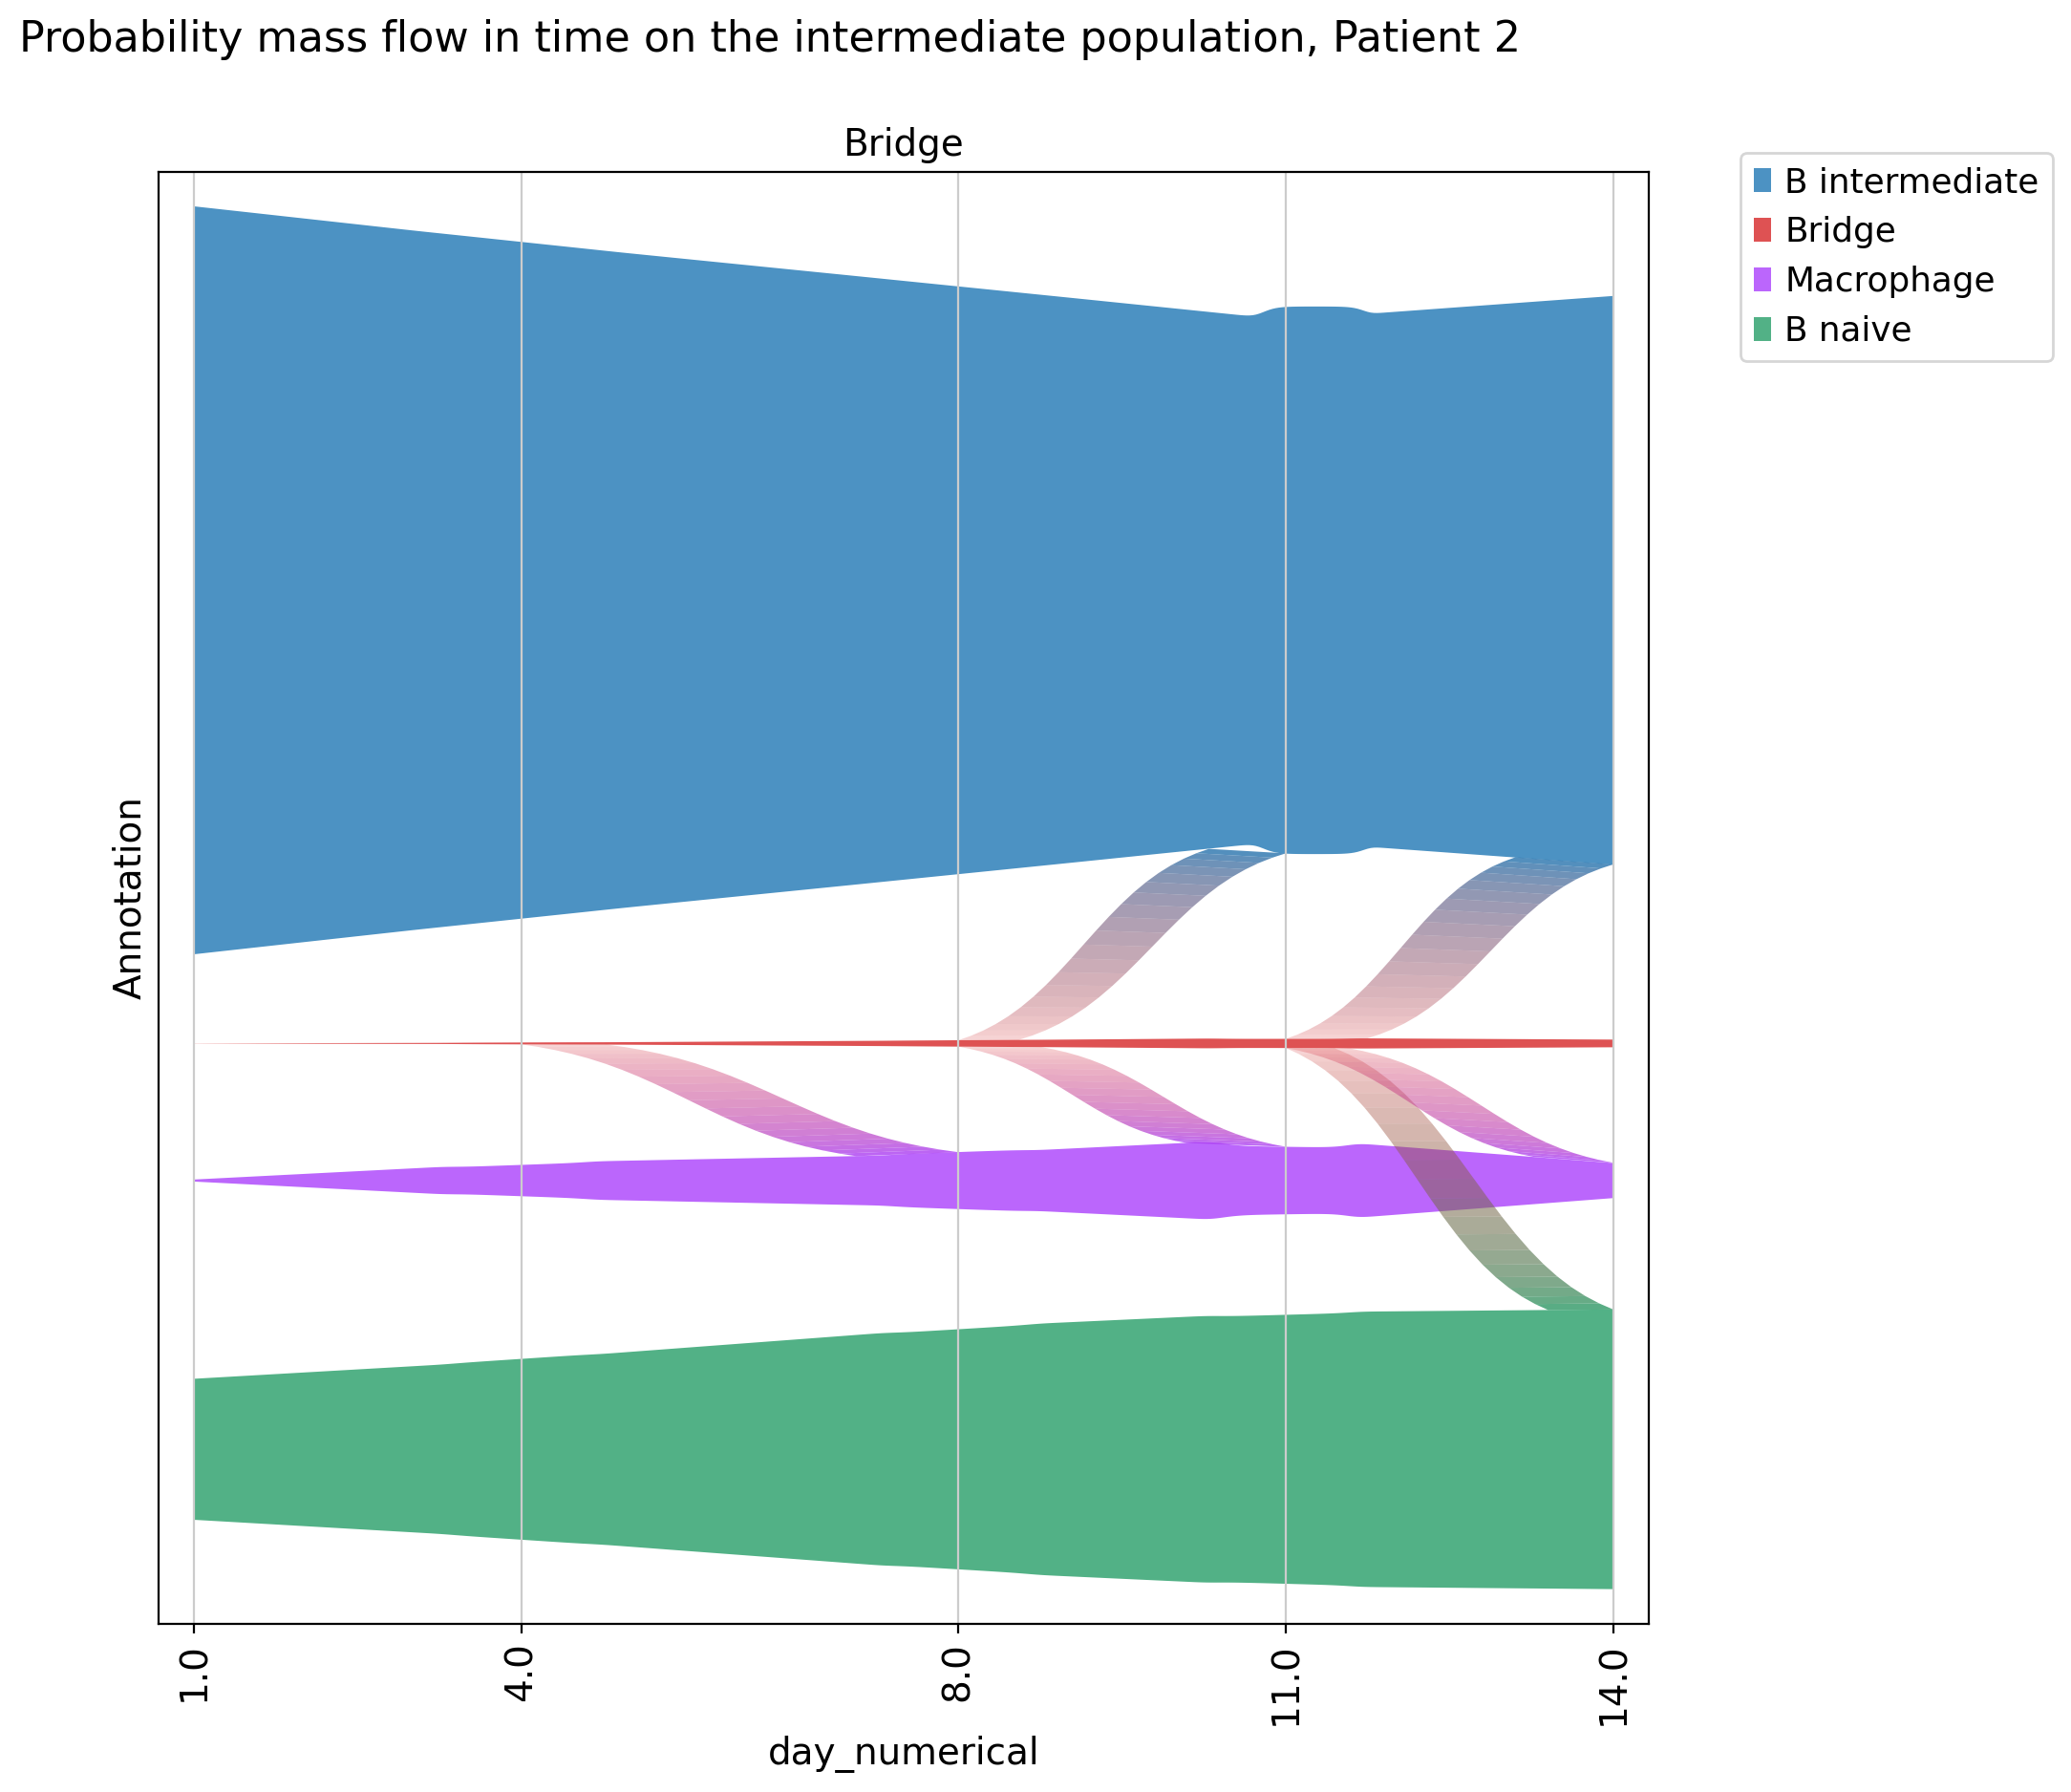

In [76]:
ax = tmk.plot_single_flow(
    cluster_key="Annotation",
    time_key="day_numerical",
    cluster="Bridge",
    min_flow=0.1,
    xticks_step_size=1,
    show=False,
    figsize=[10,10],
    clusters=["Macrophage", "Bridge", "B naive", "B intermediate"],
)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.suptitle("Probability mass flow in time on the intermediate population, Patient 2", fontsize=16, y=0.99)
plt.savefig("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/prob_flow_p2.png", dpi=300, bbox_inches='tight')

## Identify initial and terminal states : Initialize an estimator

In [77]:
g = cr.estimators.GPCCA(tmk)
print(g)

GPCCA[kernel=RealTimeKernel[n=42001], initial_states=None, terminal_states=None]


In [86]:
g.fit(cluster_key="Annotation", n_states=[4, 12])
g.plot_macrostates(
    which="all",
    discrete=True,
    legend_loc="right",
    title="Macrostates CellRank Time Serie Kernel, Patient 2", 
    s=100,
    show=False
)

plt.savefig(
    "/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/macrostates_timeseries_p2.png",
    dpi=300,
    bbox_inches="tight"
)
plt.close()

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Calculating minChi criterion in interval `[4, 12]`
Computing `4` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


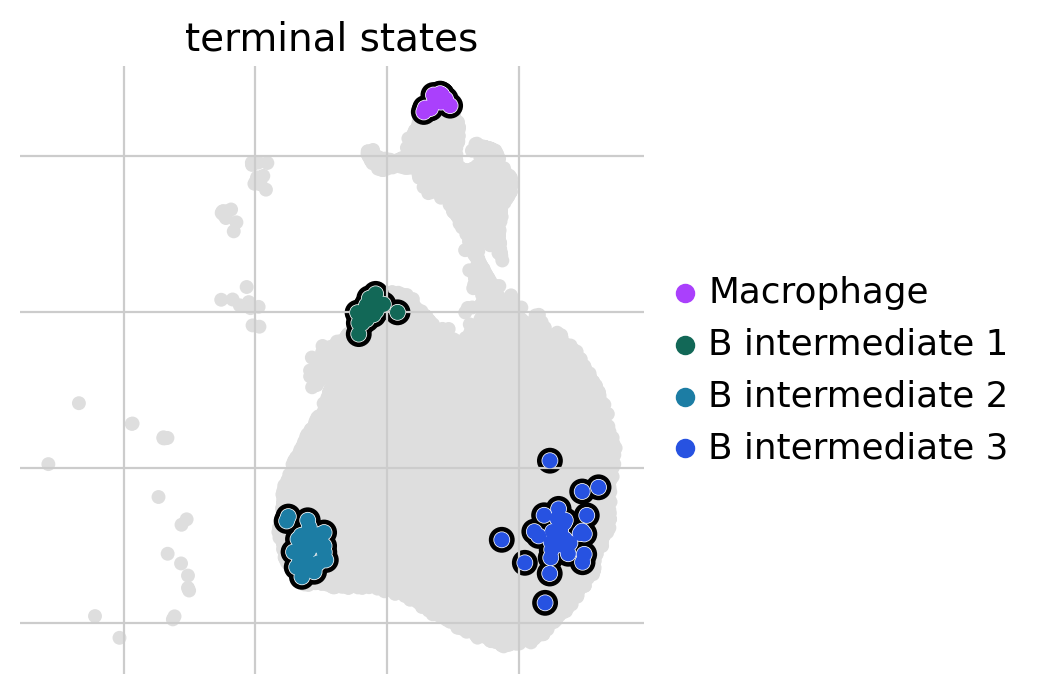

In [22]:
g.predict_terminal_states()
g.plot_macrostates(which="terminal", legend_loc="right", s=100)

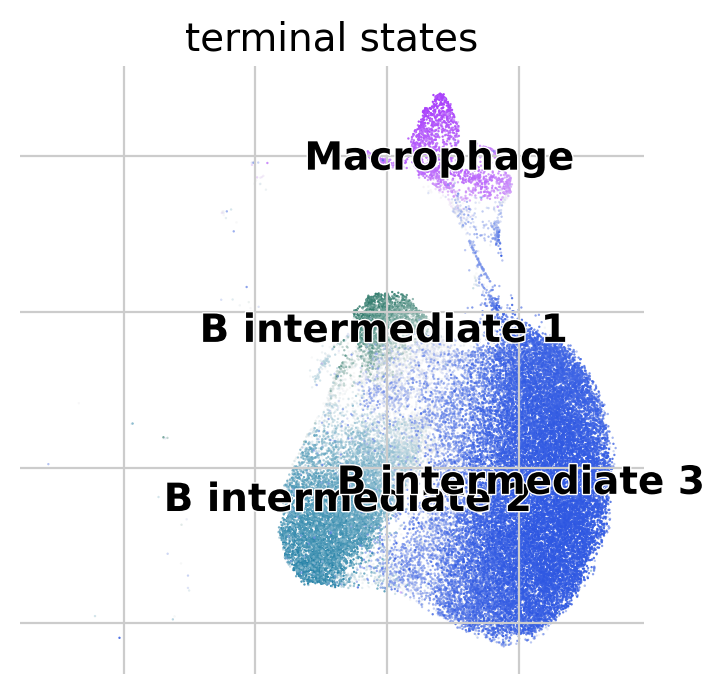

In [23]:
g.plot_macrostates(which="terminal", discrete=False)

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


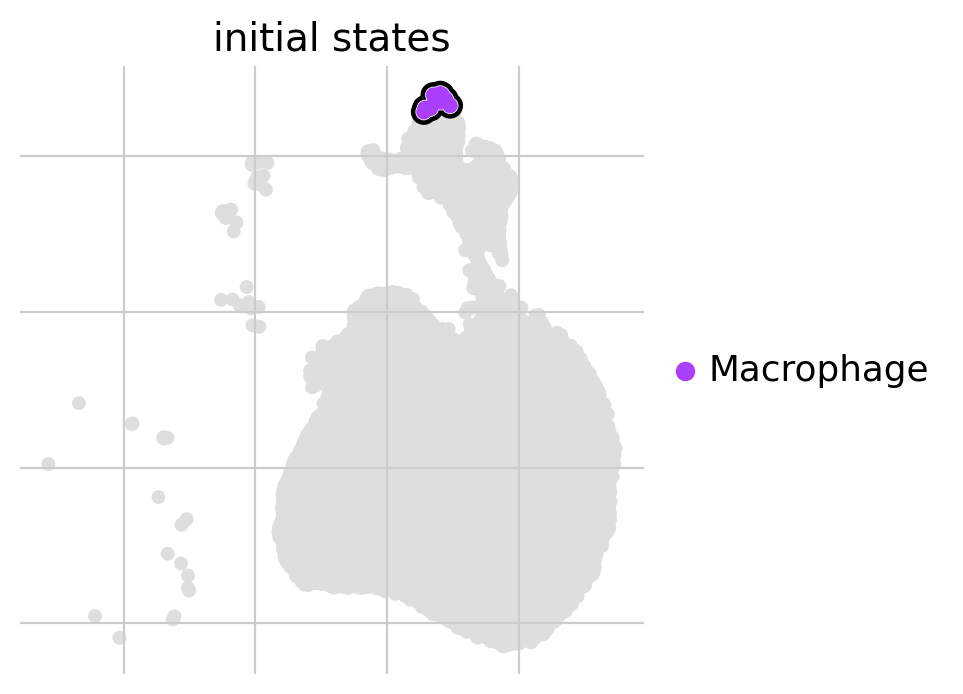

In [26]:
g.predict_initial_states(allow_overlap=True)
g.plot_macrostates(which="initial", legend_loc="right", s=100)

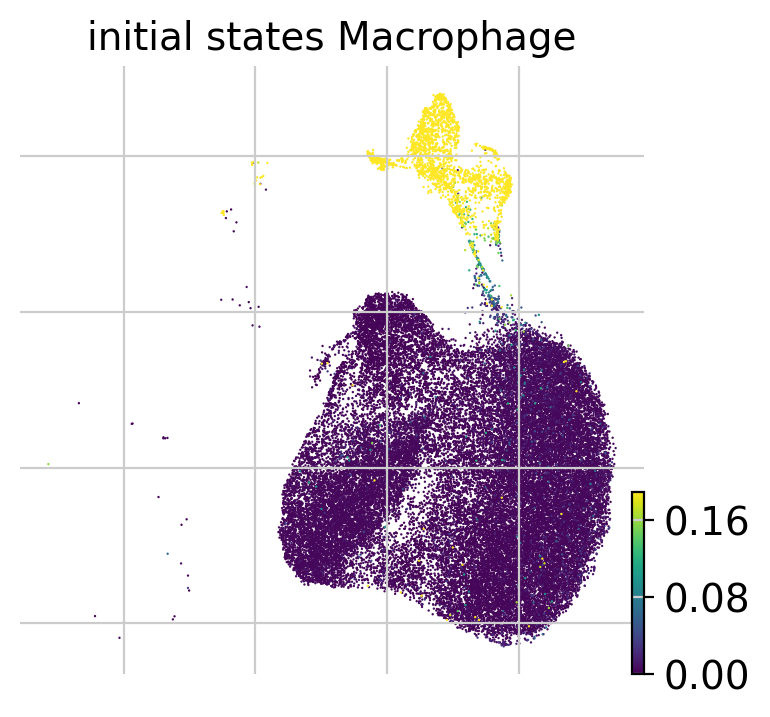

In [27]:
g.plot_macrostates(which="initial", discrete=False)

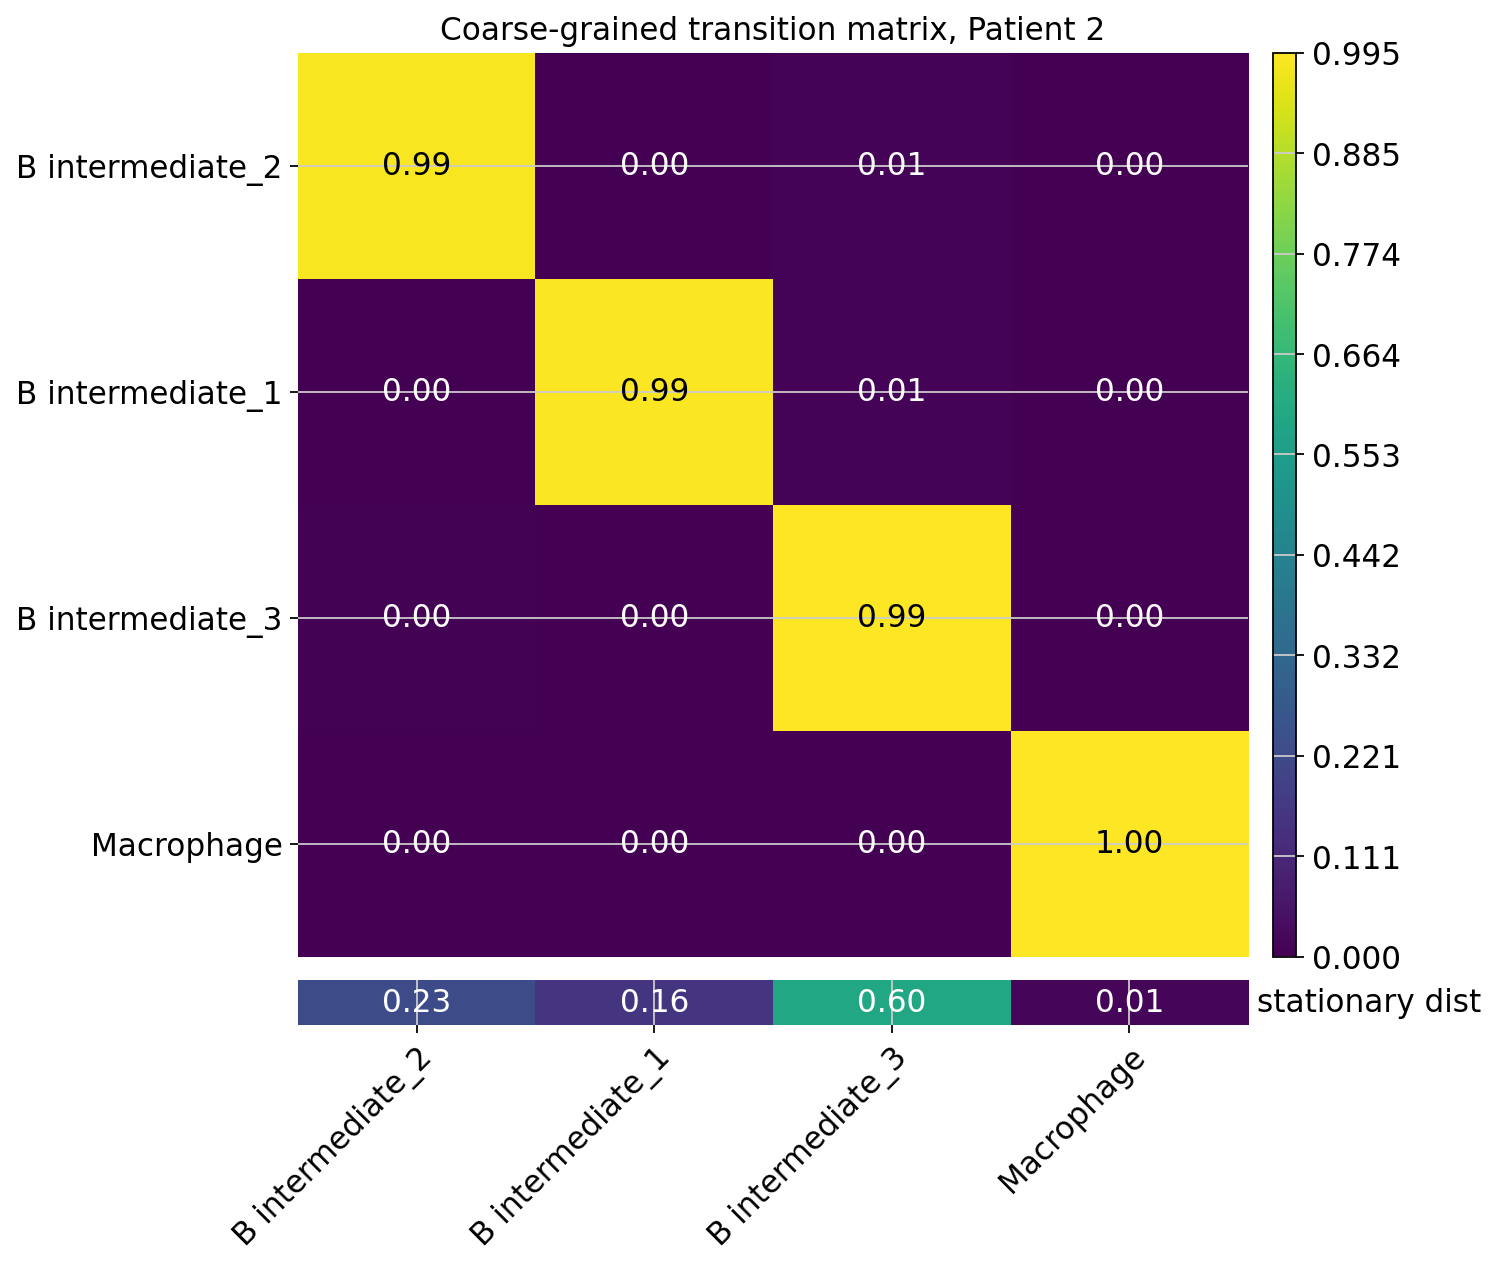

In [91]:
g.plot_coarse_T(title="Coarse-grained transition matrix, Patient 2", save="/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/coarse-grained_timeseries_p2.png")

Advanced usage

In [29]:
g2 = cr.estimators.GPCCA(tmk)
print(g2)

GPCCA[kernel=RealTimeKernel[n=42001], initial_states=None, terminal_states=None]


Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)


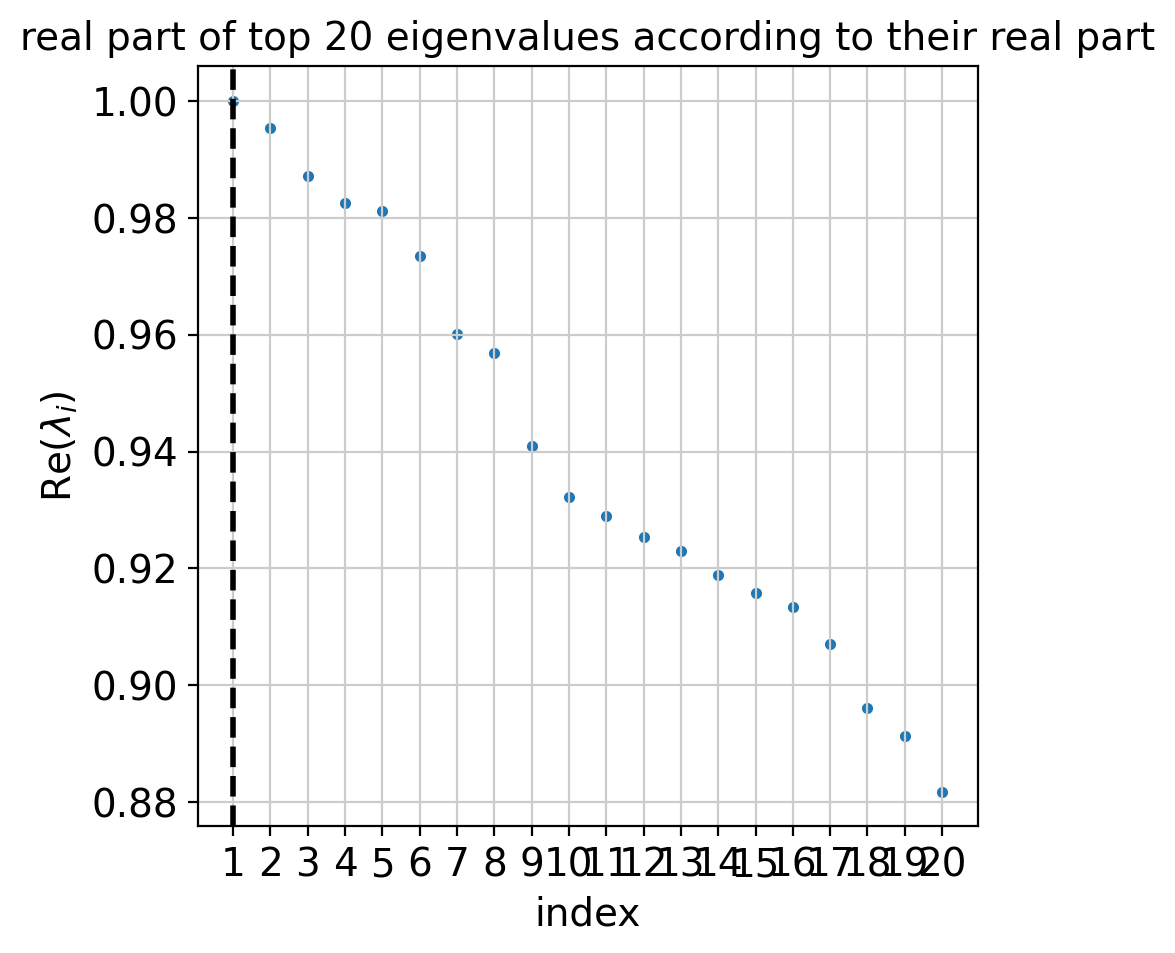

In [30]:
g2.compute_schur()
g2.plot_spectrum(real_only=True)

Computing `3` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


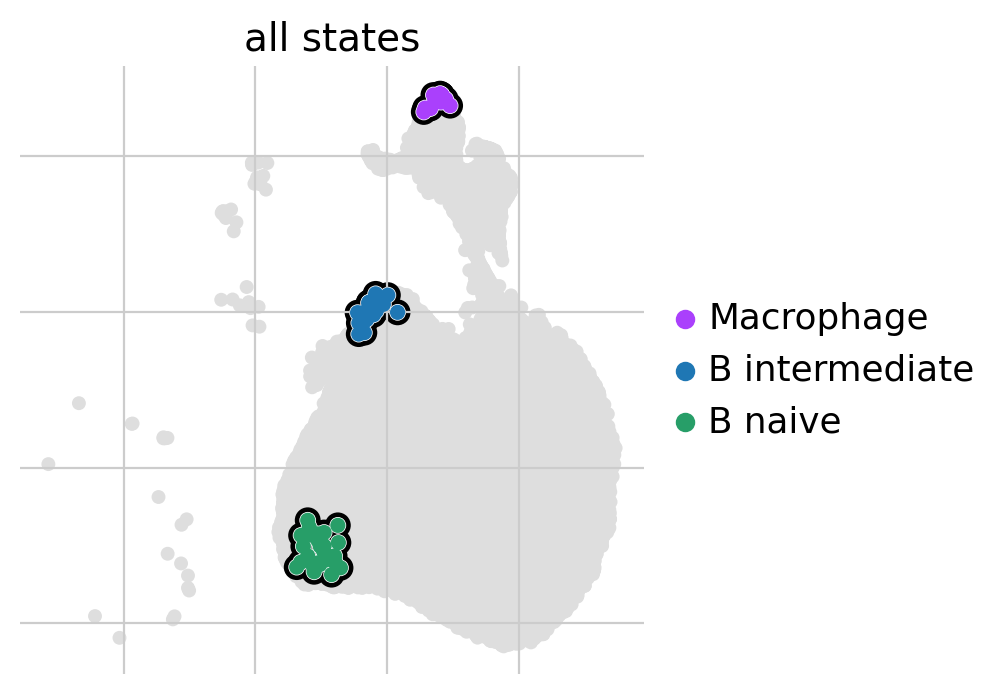

In [37]:
g2.compute_macrostates(n_states=3, cluster_key="Annotation")
g2.plot_macrostates(which="all", legend_loc="right", s=100)

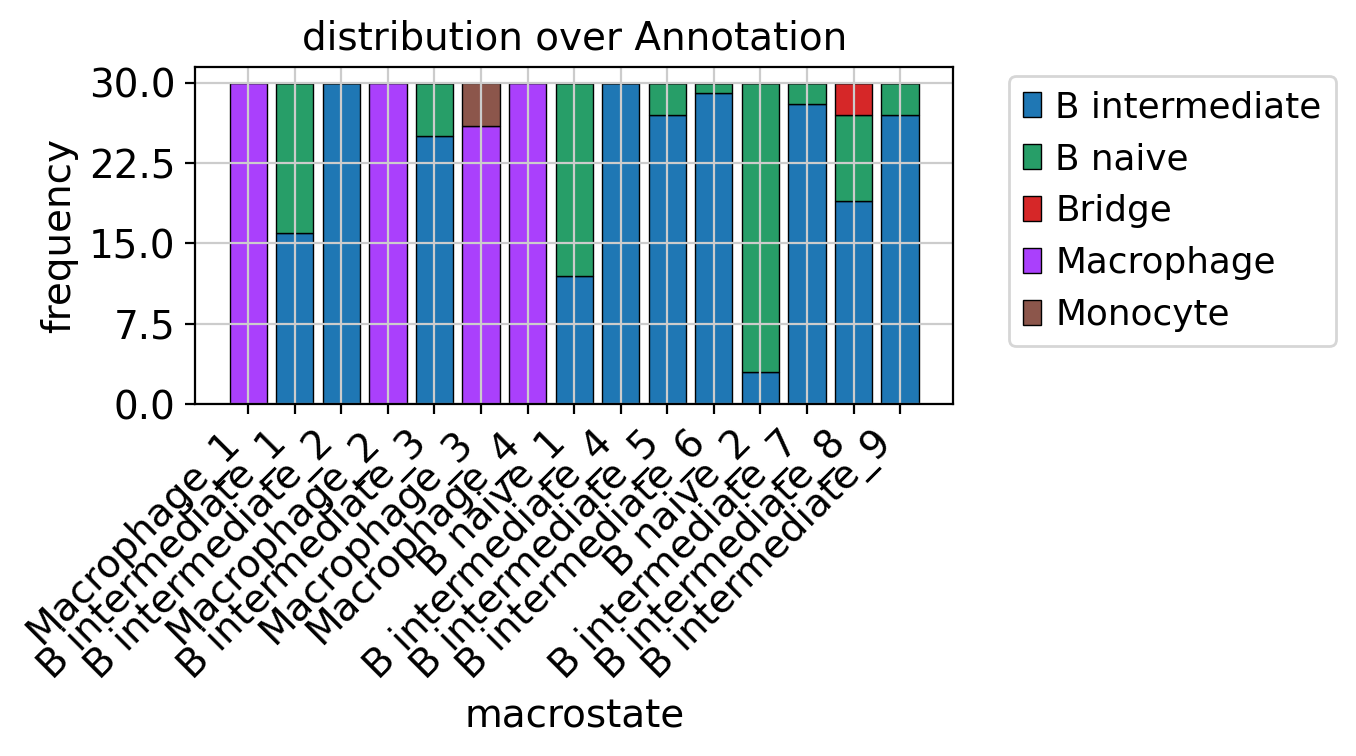

In [35]:
g2.plot_macrostate_composition(key="Annotation", figsize=(7, 4))

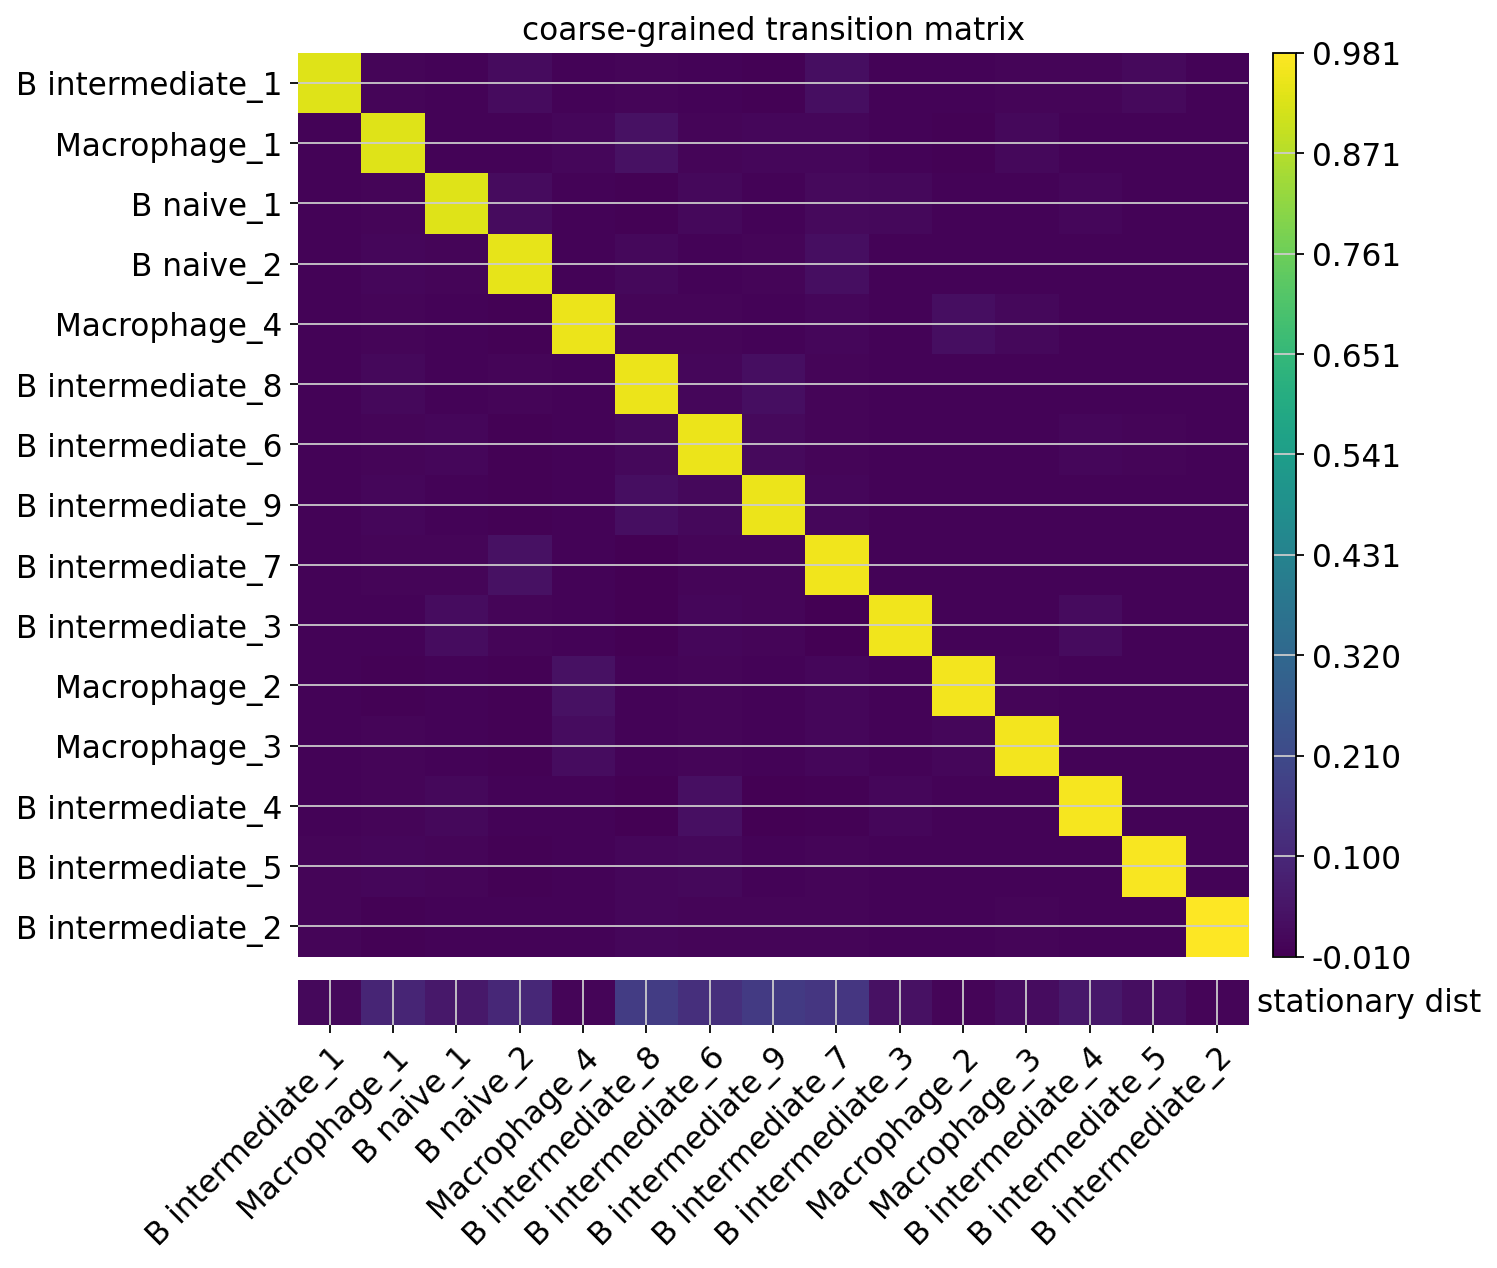

In [36]:
g2.plot_coarse_T(annotate=False)

Fate probabilities

In [92]:
g = cr.estimators.GPCCA(tmk)
print(g)

GPCCA[kernel=RealTimeKernel[n=42001], initial_states=None, terminal_states=None]


Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `2` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


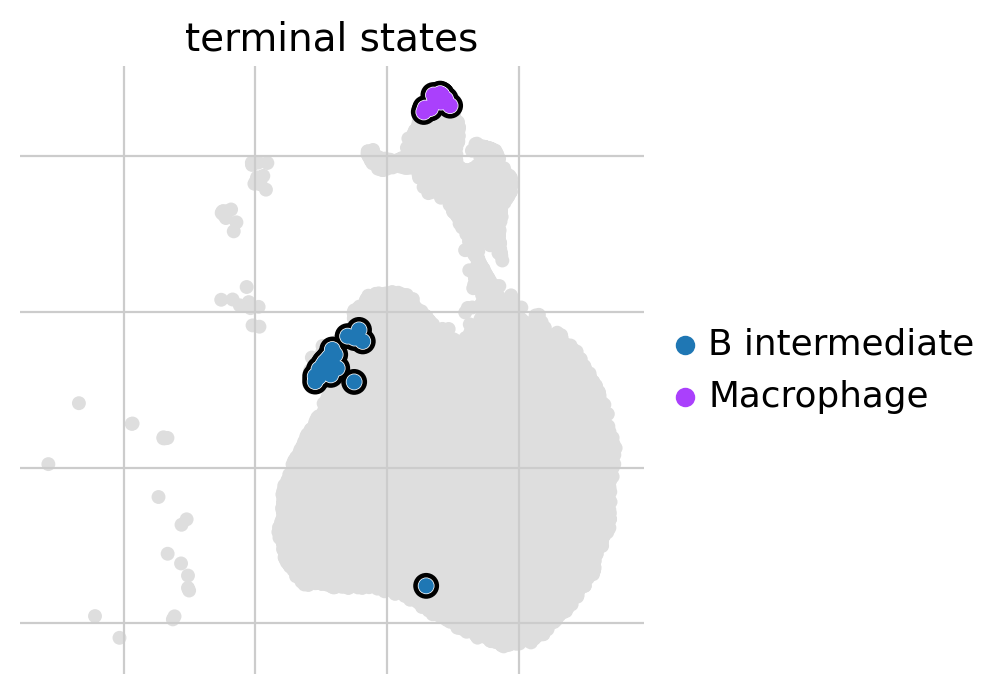

In [98]:
g.fit(cluster_key="Annotation", n_states=2)

g.set_terminal_states(states=["B intermediate", "Macrophage"])
g.plot_macrostates(which="terminal", legend_loc="right", size=100)

Computing fate probabilities


  0%|          | 0/2 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
--------------------------------------------------------------------------
MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
  Proc: [[36963,0],0]
  Errorcode: 59

NOTE: invoking MPI_ABORT causes Open MPI to kill all MPI processes.
You may or may not see output from other processes, depending on
exactly when Open MPI kills them.
--------------------------------------------------------------------------


saving figure to file /home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/fate_timeseries_p2.png


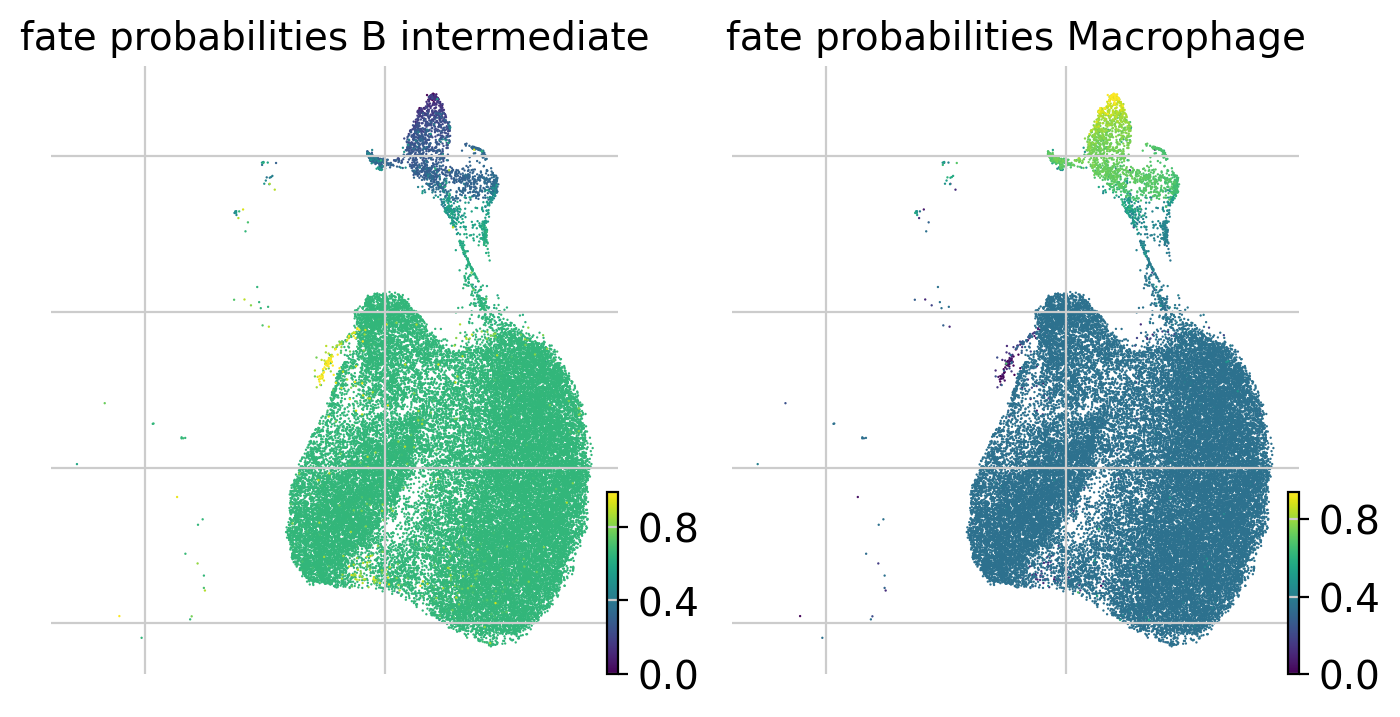

In [106]:
g.compute_fate_probabilities()
g.plot_fate_probabilities(same_plot=False,save="/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/fate_timeseries_p2.png")
#plt.savefig("/home/a.blanc-boekholt/Documents/Singlecell-R/Scripts/Plots/fate_timeseries_p2.png",dpi=300,bbox_inches="tight")
#plt.close()

In [103]:
g.plot_fate_probabilities?

Signature:
g.plot_fate_probabilities(
    states: Union[str, collections.abc.Sequence[str], NoneType] = None,
    color: Optional[str] = None,
    mode: Literal['embedding', 'time'] = 'embedding',
    time_key: Optional[str] = None,
    same_plot: bool = True,
    title: Union[str, collections.abc.Sequence[str], NoneType] = None,
    cmap: str = 'viridis',
    **kwargs: Any,
) -> None
Docstring:
Plot fate probabilities.

Parameters
----------
states
    Subset of the macrostates to show. If :obj:`None`, plot all macrostates.
color
    Key in :attr:`~anndata.AnnData.obs` or :attr:`anndata.AnnData.var` used to color the observations.
mode
    Whether to plot the probabilities in an embedding or along the pseudotime.
time_key
    Key in :attr:`~anndata.AnnData.obs` where pseudotime is stored. Only used when ``mode = 'time'``.
title
    Title of the plot.
same_plot
    Whether to plot the data on the same plot or not. Only use when ``mode = 'embedding'``.
    If `True` and ``discrete = Fal

Test on monocytes + macrophages

In [38]:
cell_types_to_keep = ['Monocyte', 'Macrophage',]
sadata = adata[adata.obs['Annotation'].isin(cell_types_to_keep)].copy()

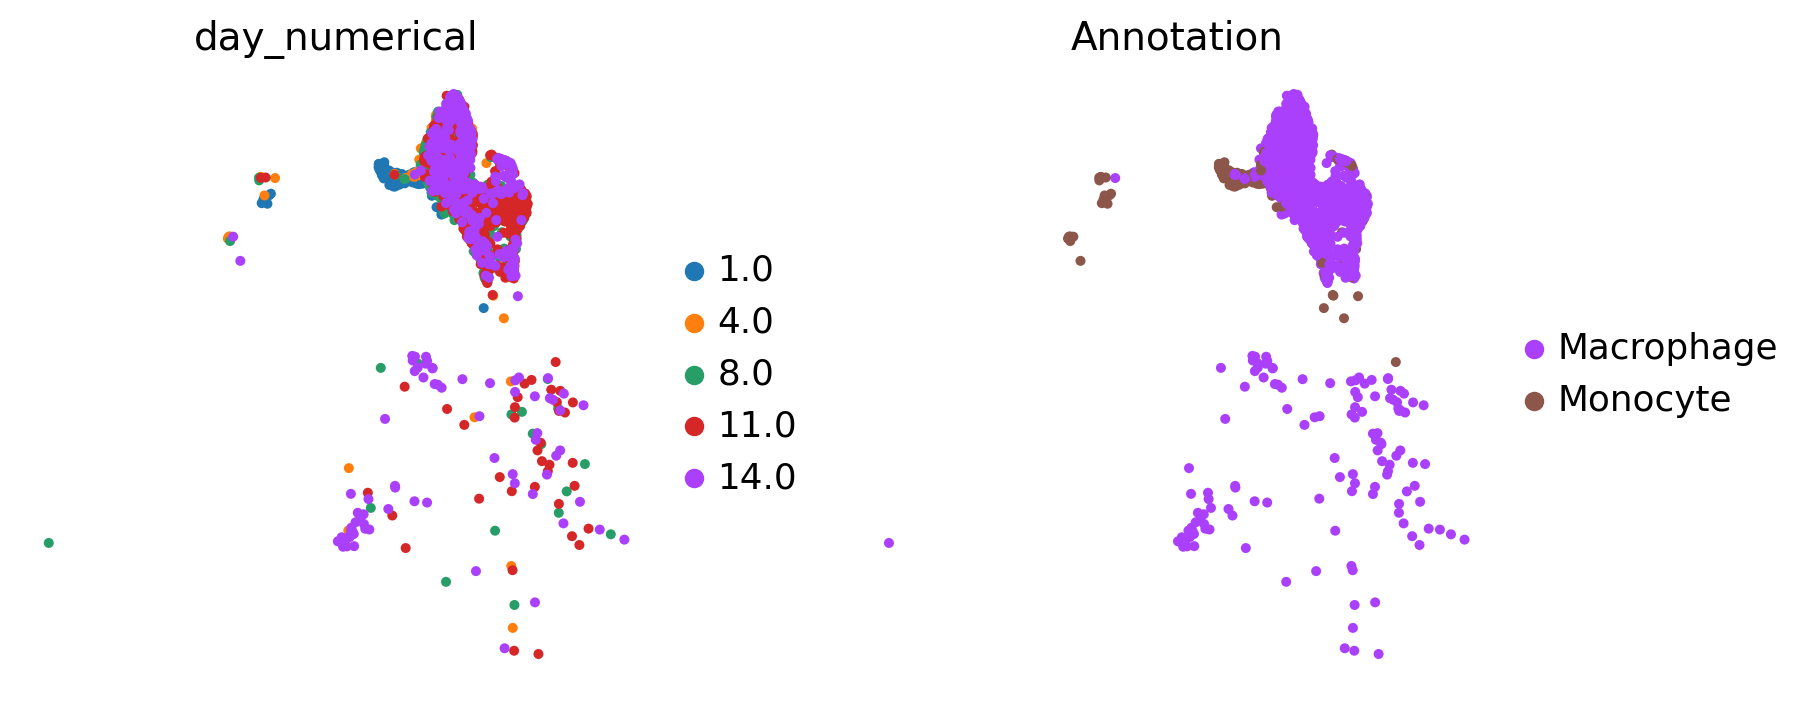

In [43]:
sc.pl.embedding(
    sadata,
    basis= "X_umap",
    color=["day_numerical", "Annotation"],
    color_map="gnuplot",
)

In [39]:
tp = TemporalProblem(sadata)
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="human", gene_set_apoptosis="human"
)
tp = tp.prepare(time_key="day_numerical")
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

computing score 'proliferation'
    finished (0:00:00)
computing score 'apoptosis'
    finished (0:00:00)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:00)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:01)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:01)
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
computing PCA
    with n_comps=30
    finished (0:00:00)
INFO     Solving `4` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(295, 493)].       

In [40]:
tmk = RealTimeKernel.from_moscot(tp)
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

  0%|          | 0/4 [00:00<?, ?time pair/s]

Using automatic `threshold=0.0`


RealTimeKernel[n=2316, threshold='auto', self_transitions='all']

Simulating `100` random walks of maximum length `500`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:02)
Plotting random walks


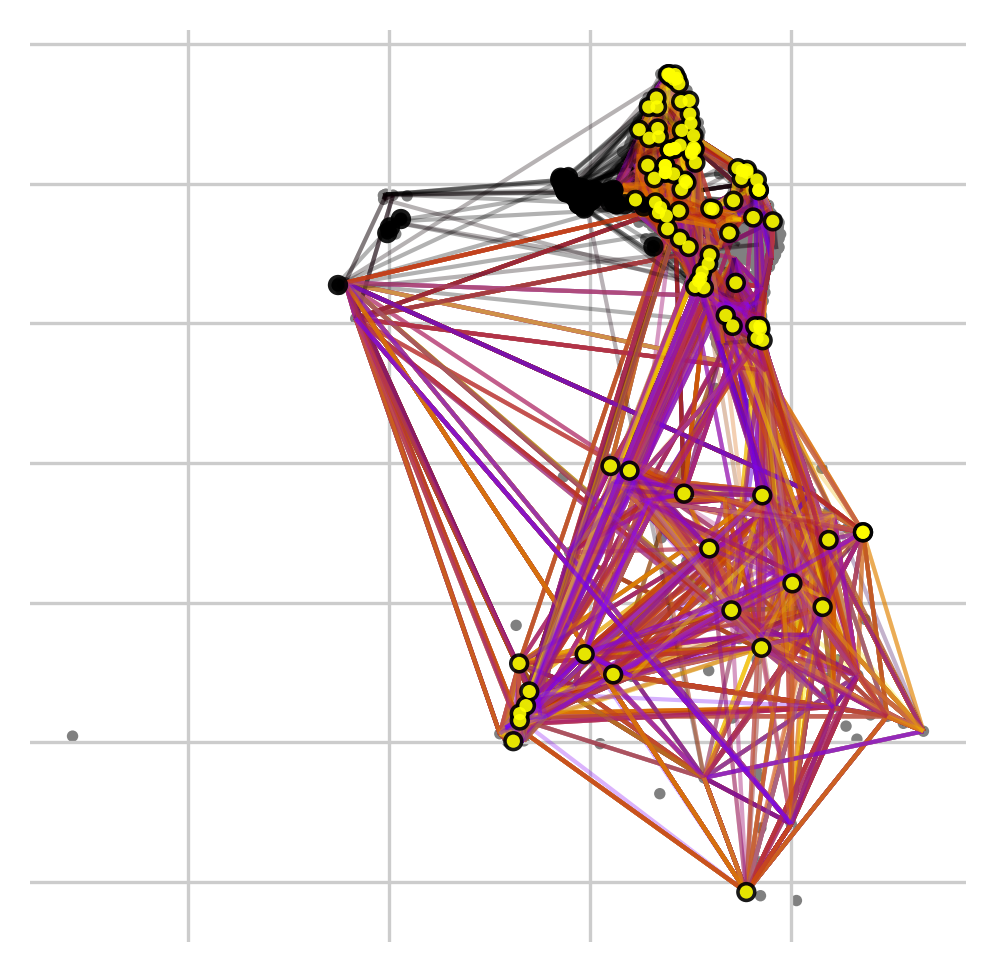

In [41]:
tmk.plot_random_walks(
    max_iter=500,
    start_ixs={"day_numerical": 1.0},
    basis="X_umap",
    seed=0,
    dpi=150,
    size=30,
)

Computing flow from `Monocyte` into `1` cluster(s) in `4` time points
Plotting flow from `Monocyte` into `1` cluster(s) in `4` time points


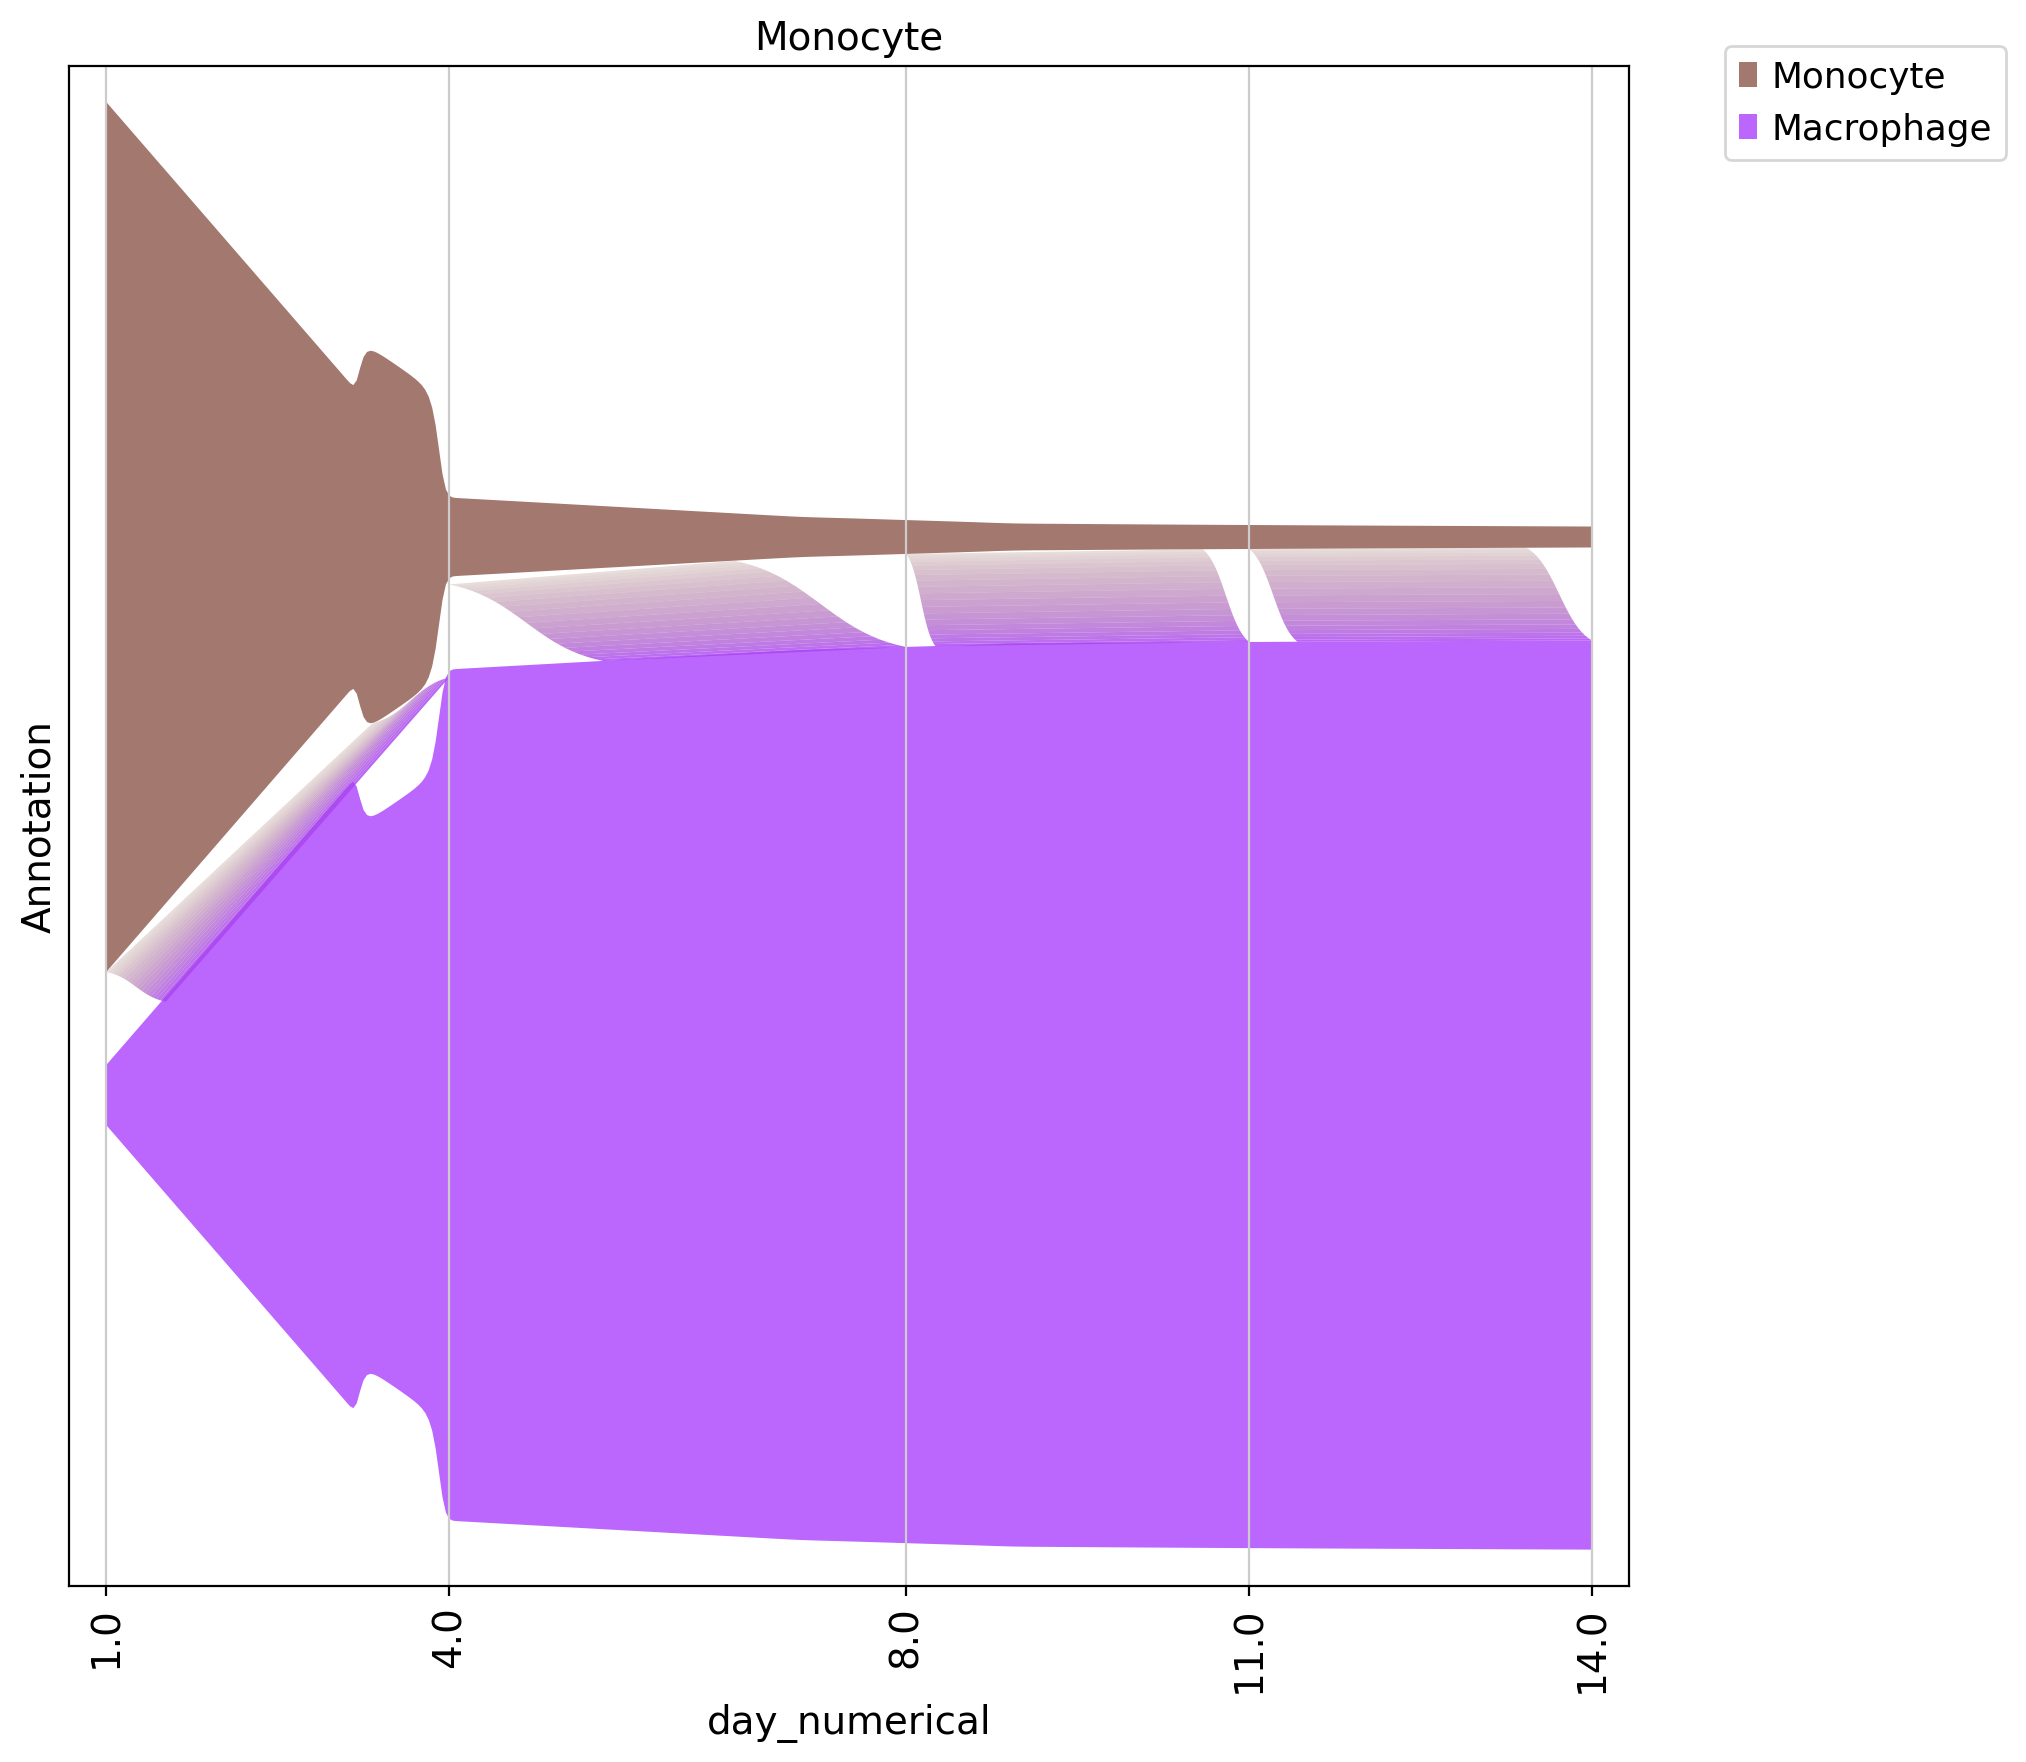

In [47]:
ax = tmk.plot_single_flow(
    cluster_key="Annotation",
    time_key="day_numerical",
    cluster="Monocyte",
    min_flow=0.1,
    xticks_step_size=1,
    show=False,
    figsize=[10,10],
)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [50]:
g2 = cr.estimators.GPCCA(tmk)
print(g2)

GPCCA[kernel=RealTimeKernel[n=2316], initial_states=None, terminal_states=None]


Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-238' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/a.blanc-boekholt/miniconda3/envs/cellrank-env/lib/python3.11/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-239' coro=<Kernel.shell_main() running at /home/a.blanc-boekholt/miniconda3/envs/cellrank-env/lib/python3.11/site-packages/ipykernel/kernelbase.py:597> cb=[Task.task_wakeup()]> cb=[ZMQStream._run_callback.<locals>._log_error() at /home/a.blanc-boekholt/miniconda3/envs/cellrank-env/lib/python3.11/site-packages/zmq/eventloop/zmqstream.py:563]>
ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-239' coro=<Kernel.shell_main() running at /home/a.blanc-boekholt/miniconda3/envs/cellrank-env/lib/python3.11/site-packages/ipykernel/kernelbase.py:597> cb=[Task.task_wakeup()]>


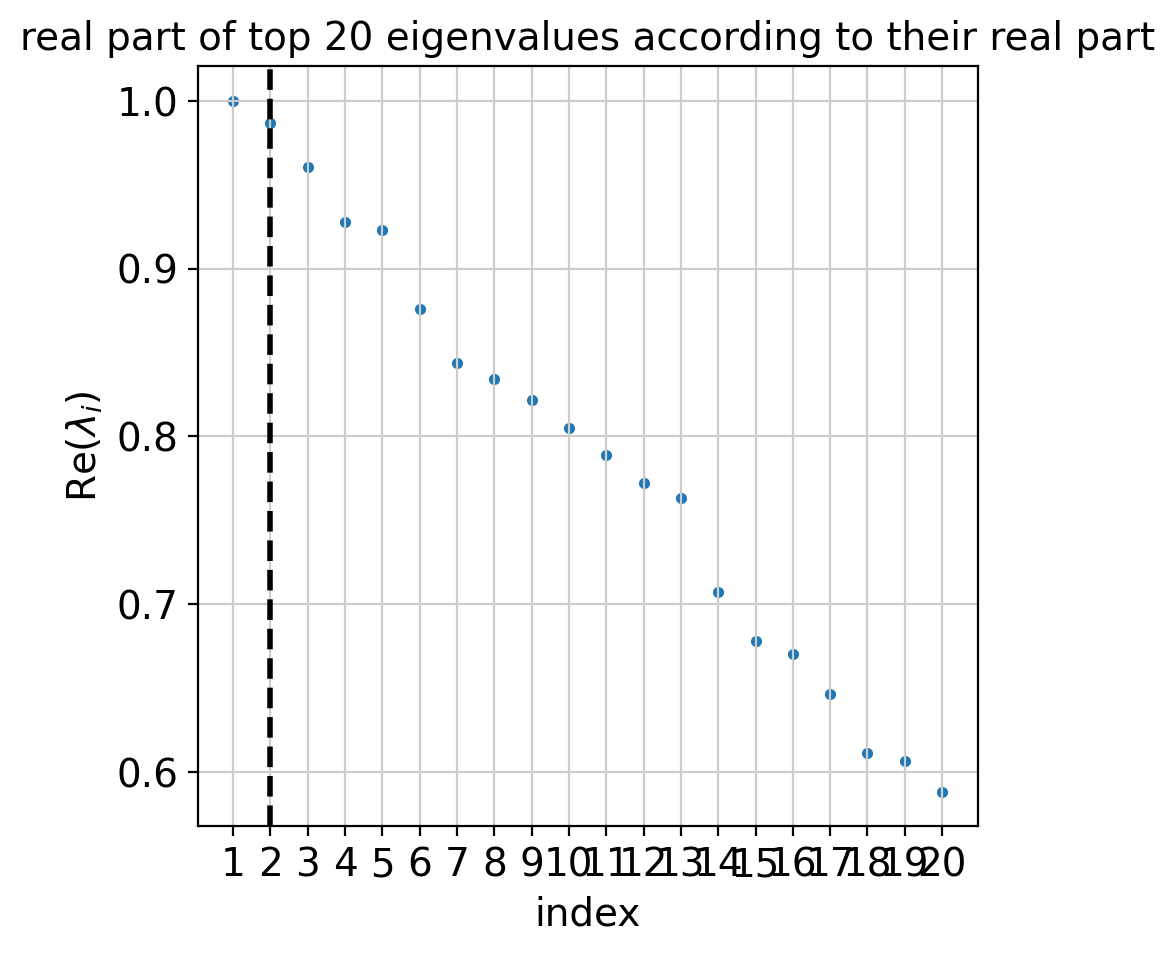

In [51]:
g2.compute_schur()
g2.plot_spectrum(real_only=True)

Computing `5` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


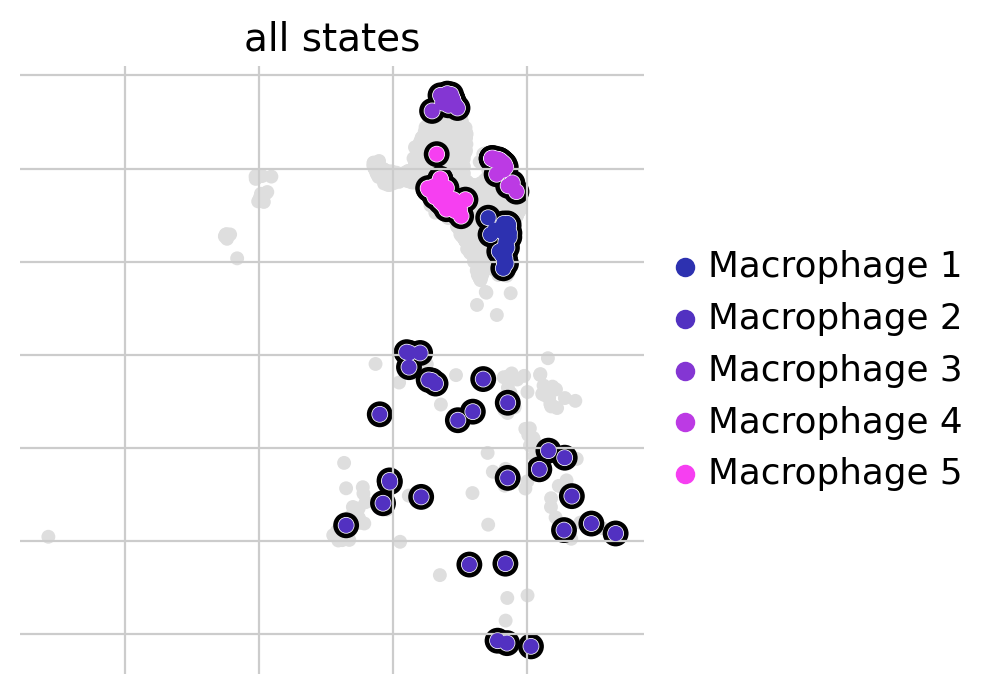

In [56]:
g2.compute_macrostates(n_states=5, cluster_key="Annotation")
g2.plot_macrostates(which="all", legend_loc="right", s=100)

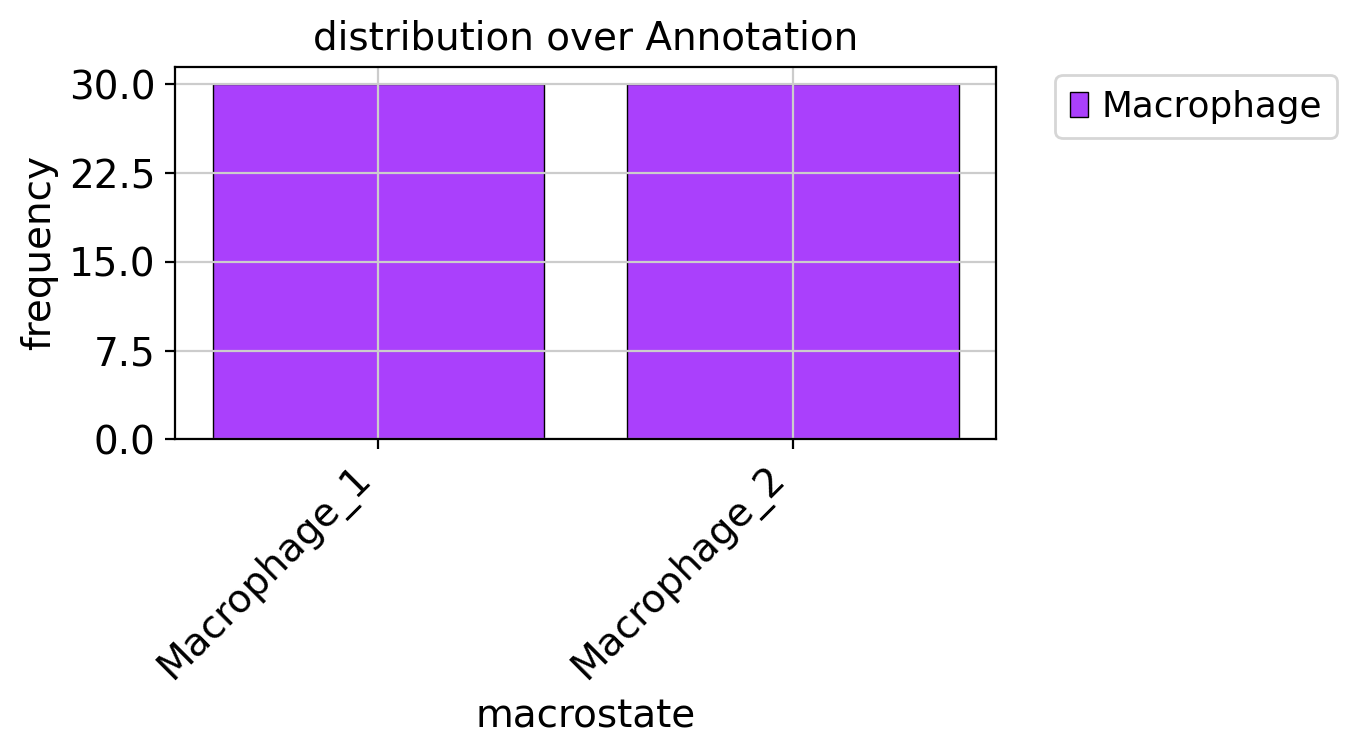

In [53]:
g2.plot_macrostate_composition(key="Annotation", figsize=(7, 4))

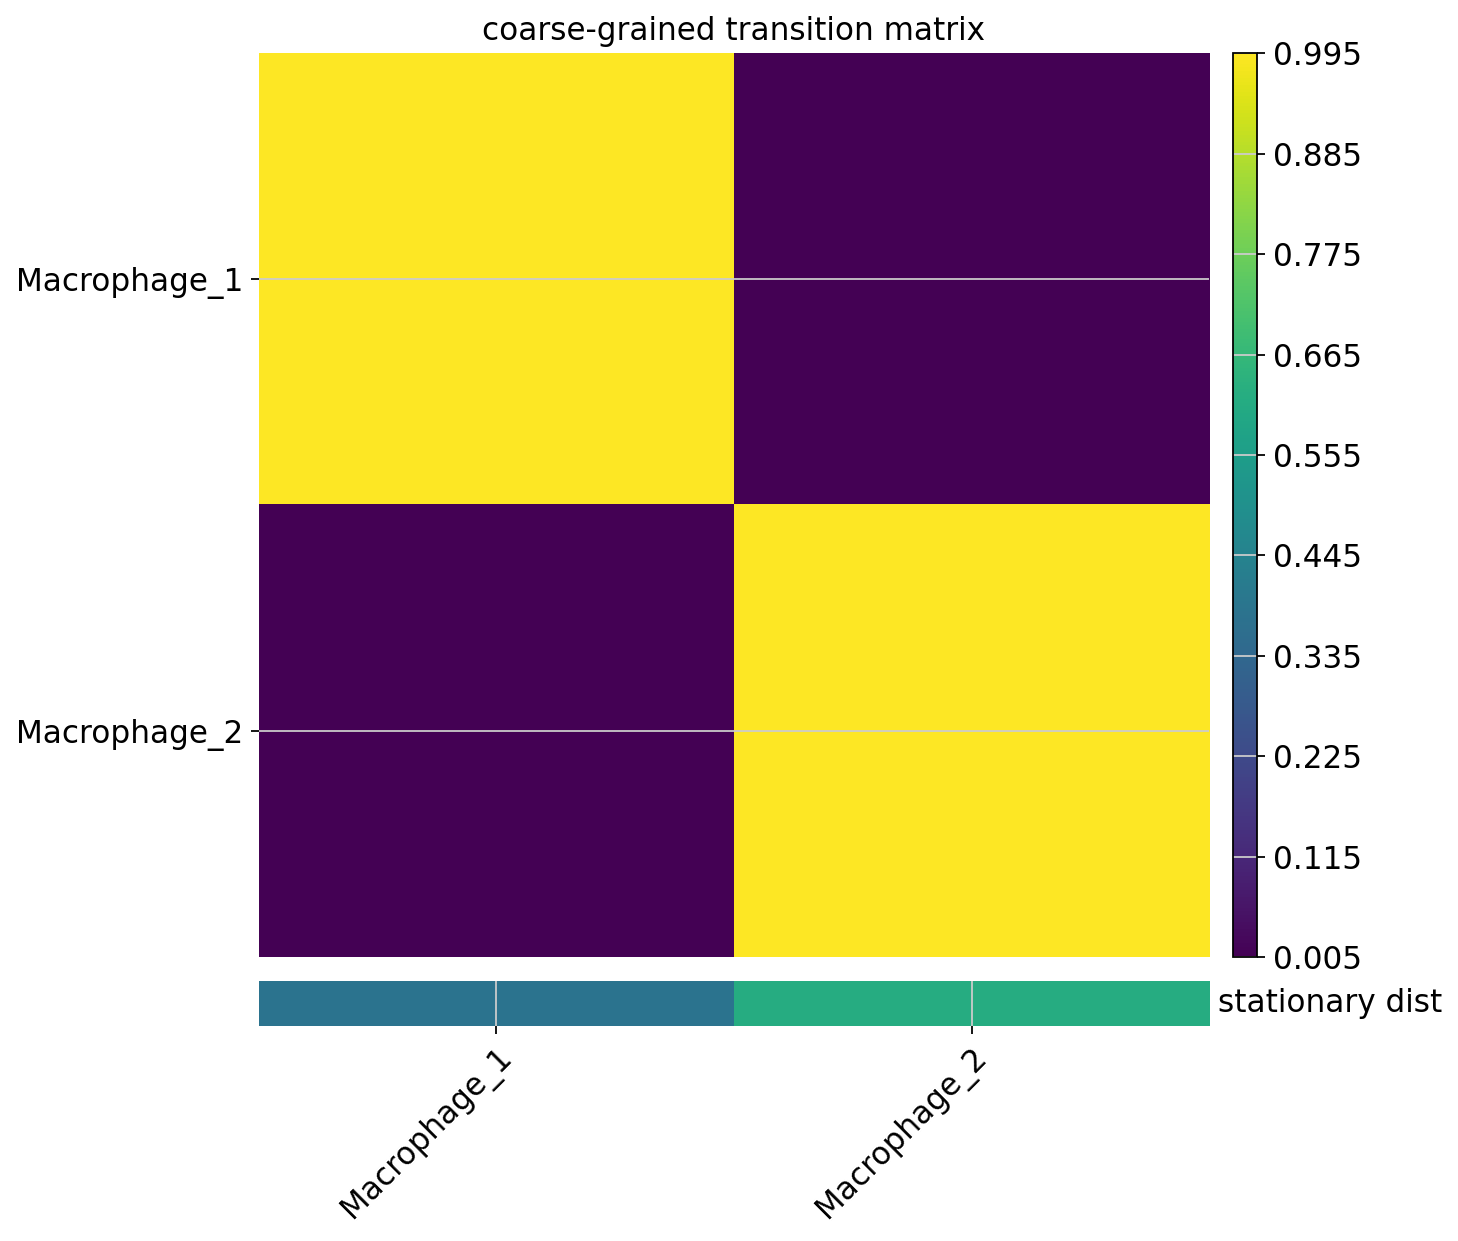

In [54]:
g2.plot_coarse_T(annotate=False)